<img src="https://raw.githubusercontent.com/CristianR8/Imagenes-Espectrales-Sesion4-Parte1-HoCV/main/images/banner-spectral.png" width="1000" align="middle"/>


# <font color='#ECA702'>**Hands-on Sesión 4: Clasificacion espectral 📸 🌈**</font>

# <font color='#4C5FDA'>**Objetivo**</font>



El objetivo de la clasificación hiperespectral es clasificar cada píxel/punto de datos en una de $K$ clases.  En general, los métodos de clasificación son más eficaces que los de desmezcla hiperespectral. Sin embargo, los métodos de clasificación no son eficaces a la hora de determinar las cantidades de proporción subpíxel o la cantidad de un material que puede encontrarse dentro del campo de visión correspondiente a un píxel.  

En general, los enfoques de clasificación hiperespectral implican:
1. (opcionalmente) extracción de características
2. aplicación de un clasificador estándar (es decir, clasificadores de la bibliografía sobre aprendizaje automático).

Para esta sesión haremos uso de 3 clasificadores comunes segun el estado del arte en la clasificacion espectral de imágenes

# <font color='#4C5FDA'>**Explicación métricas empleadas**</font>


- Precisión (Accuracy): La precisión es probablemente la métrica más directa y sencilla para entender. Imagina que tienes un conjunto de imágenes y un clasificador que intenta identificar si cada imagen contiene o no un perro. Si el clasificador evalúa 100 imágenes y acierta (correctamente identifica si hay o no un perro) en 90 de ellas, entonces la precisión del clasificador es del 90%. En términos matemáticos, la precisión se calcula como el número de predicciones correctas (tanto positivas como negativas) dividido por el número total de predicciones hechas. Se puede expresar como:

<div style="text-align: center;">
  <img src="https://raw.githubusercontent.com/CristianR8/Imagenes-Espectrales-Sesion4-Parte1-HoCV/main/images/accuracy.png" alt="Imagenes espectrales" style="width: 400px;"/>
</div>

- Índice de Jaccard: El índice de Jaccard, también conocido como la Intersección sobre la Unión (IoU), es una medida un poco más sofisticada que se usa especialmente para evaluar la calidad de los clasificadores en tareas de segmentación de imágenes, donde no solo importa saber si una imagen contiene un objeto específico, sino también dónde está ese objeto dentro de la imagen.  Se calcula como la intersección (el área que ambos rectángulos, el predicho y el verdadero, comparten) dividida por la unión (el área total cubierta por ambos rectángulos, sin contar dos veces las áreas que se superponen). Esto se expresa matemáticamente como:

<div style="text-align: center;">
  <img src="https://raw.githubusercontent.com/CristianR8/Imagenes-Espectrales-Sesion4-Parte1-HoCV/main/images/jaccard.webp" alt="Imagenes espectrales" style="width: 400px;"/>
</div>


**Al finalizar este Notebook deberas obtener una grafica comparativa con las predicciones de los tres clasificadores propuestos**

<div style="text-align: center;">
  <img src="https://raw.githubusercontent.com/CristianR8/Imagenes-Espectrales-Sesion4-Parte1-HoCV/main/images/objetivo.png" alt="Imagenes espectrales" style="width: 700px;"/>
</div>

# <font color='#4C5FDA'>**Importamos datos necesarios**</font>

In [7]:
# NO MODIFIQUES ESTA CELDA
%%capture
!pip install gdown
!gdown --id 1ob4CwfeG-g2PWaxJdnmFnF4gB0e9Dd8d #PaviaU_gt.mat
!gdown --id 1ZjpMKaMTSLbM4x3XpMCpootVjkLiFWde #PaviaU.mat
!gdown --id 13X3I26JniCKag4DTrXF6d8f3xBs2o7Td #QPP.py
!gdown --id 14BTtiRg0BEP30PBULLUQ-NWG3ydmsyyH #SPICE.py
!gdown --id 1XP2gip7PFl04ojFoAsWaJ9hdeCFXfU9Y #cnn_x_test.pth
!gdown --id 14kwBxZOU1ttYacU0P37bgRK8cXcM7tOB #cnn_x_train.pth
!gdown --id 1zXFhgjAbN38P1sZxOTTEnpaj72ZKQmx4 #cnn_y_test.pth
!gdown --id 14rAst2xEdoAeT5M-JZOGrlx2piAjmV67 #cnn_y_train.pth
!gdown --id 1gxVjW0v-1e11-iGUfQHdmpjvkWtb4nie #model_pca.pkl
!gdown --id 1vXEziBRgej4-PFYn5b5aQhMchLZZtOdb #complete_model.pth

# <font color='#4C5FDA'>**Importamos librerias**</font>

In [8]:
%%capture
!pip install earthpy

In [9]:
from scipy.io import loadmat
import earthpy.spatial as es
import earthpy.plot as epp
import pandas as pd
import numpy as np
import warnings
import joblib
import seaborn as sns
import torch.nn.functional as F
import torch.utils.data as data_utils
import seaborn as sns
import torch
import matplotlib.colors as mcolors
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, jaccard_score
from torch import nn
from torch import optim



sns.set()
warnings.filterwarnings("ignore")

## <font color='#4C5FDA'>**Información del Dataset**</font>

El conjunto de datos de la Universidad de Pavía es un conjunto de datos de imágenes hiperespectrales recogidas por un sensor conocido como espectrómetro de imágenes de sistema óptico reflectante (ROSIS-3) sobre la ciudad de Pavía, Italia. La imagen consta de 610×340 píxeles con 115 bandas espectrales. La imagen se divide en 9 clases con un total de 42.776 muestras etiquetadas, entre las que se incluyen el asfalto, los prados, la grava, los árboles, la chapa metálica, el suelo desnudo, el betún, el ladrillo y la sombra.

<div style="text-align: center;">
  <img src="https://raw.githubusercontent.com/CristianR8/Imagenes-Espectrales-Sesion4-Parte1-HoCV/main/images/paviau.jpg" alt="Imagenes espectrales" style="width: 600px;"/>
</div>

In [10]:
# No me esta descargar el archivo paviaU.mat.
%%capture
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=9875c597cd454688c6bb93cf20fbb084d4fda47cf3471e714cc5e1cb78539502
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [18]:
import wget

url = "https://www.ehu.eus/ccwintco/uploads/e/ee/PaviaU.mat"
PaviaU = wget.download(url)

In [19]:
paviaUData = loadmat(PaviaU)


In [31]:
print(paviaUData.keys())
print(paviaUData['paviaU'].shape)


dict_keys(['__header__', '__version__', '__globals__', 'paviaU'])
(610, 340, 103)


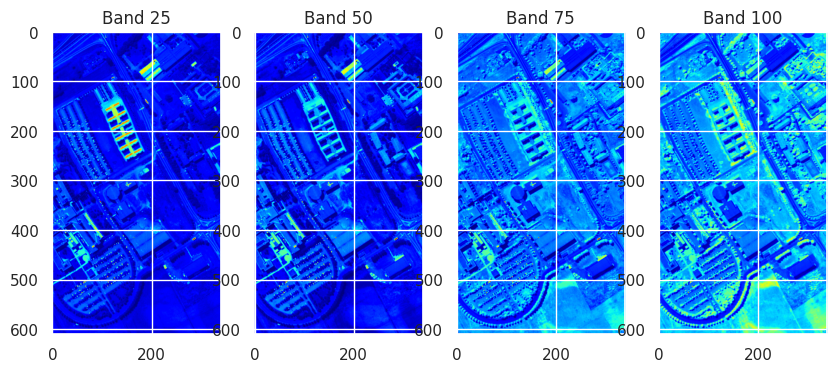

In [40]:
rr,cc = 100,100
hsi = paviaUData['paviaU']
spectrum = hsi[rr,cc,:]

# No hay valores especificos para el wavelenght

fig,axis = plt.subplots(1,4,figsize=(10,4))
axis[0].imshow(hsi[:,:,25],cmap='jet')
axis[0].set_title('Band 25')
axis[1].imshow(hsi[:,:,50],cmap='jet')
axis[1].set_title('Band 50')
axis[2].imshow(hsi[:,:,75],cmap='jet')
axis[2].set_title('Band 75')
axis[3].imshow(hsi[:,:,100],cmap='jet')
axis[3].set_title('Band 100')
plt.show()

dict_keys(['__header__', '__version__', '__globals__', 'paviaU_gt'])
(610, 340)


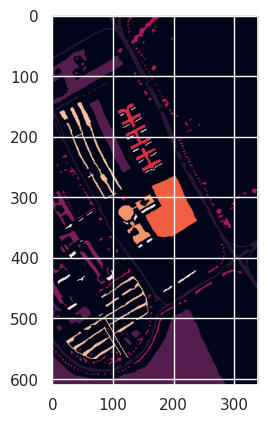

In [24]:
PaviaU_gt = loadmat('PaviaU_gt.mat')
print(PaviaU_gt.keys())
print(PaviaU_gt['paviaU_gt'].shape)

plt.imshow(PaviaU_gt['paviaU_gt'])

# <font color='#4C5FDA'><small>**Cargamos el conjunto de datos**</small></font>

In [6]:
def load_paviau_dataset(data_path, ground_truth_path):

    data = loadmat(data_path)
    gt = loadmat(ground_truth_path)

    # Assuming the variable names in the .mat files are 'paviaU' and 'paviaU_gt' respectively.
    # Adjust the keys if they are different in your dataset files.
    img = data['paviaU']
    gt = gt['paviaU_gt']

    return img, gt

# Funcion de preprocesamiento
def preprocess_data(img, gt):
    n_rows, n_cols, n_bands = img.shape
    pixels = img.reshape((n_rows*n_cols, n_bands))
    labels = gt.ravel()
    return pixels, labels




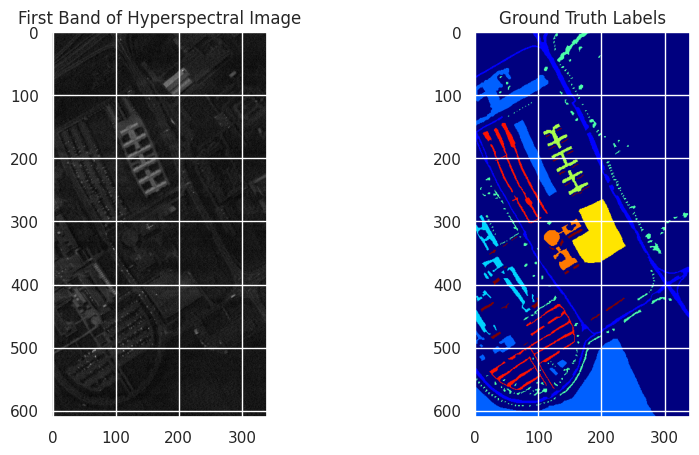

In [37]:
# Ejemplo de uso
data_path = 'PaviaU.mat'
ground_truth_path = 'PaviaU_gt.mat'
img, gt = load_paviau_dataset(data_path, ground_truth_path)

# Visualizar la primera banda de la imagen y la verdad fundamental para verificar
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img[:, :, 0], cmap='gray')
plt.title('First Band of Hyperspectral Image')
plt.subplot(1, 2, 2)
plt.imshow(gt, cmap='jet')
plt.title('Ground Truth Labels')
plt.show()

# <font color='#4C5FDA'><small>**Preparación de los datos para el clasificador KNN**</small></font>


Ahora podemos importar nuestro conjunto de datos de imágenes aéreas y convertirlo en un formato tabular para facilitar las operaciones de procesamiento sobre él. En este caso, cada banda de imagen se convierte en una columna **(¡tenemos más de 100 bandas!)**, y se crea una columna de clase para almacenar los datos sobre nuestras etiquetas, con cada objeto clasificado posible representado como un número (en total 10). Luego se eliminan los elementos asociados con la clase 0, ya que la clase 0 se ha utilizado como una categoría general para todos los objetos no clasificados en la imagen.

In [41]:
# NO MODIFIQUES ESTA CELDA
n_rows, n_cols, n_bands = img.shape  # Obtiene las dimensiones de la imagen: filas, columnas y bandas espectrales
pixels = img.reshape((n_rows*n_cols, n_bands))  # Reorganiza la imagen en una matriz de píxeles (cada píxel con sus bandas espectrales)
labels = gt.ravel()  # Aplana el array de etiquetas del terreno para que coincida con la estructura de los píxeles
pixels, labels  # Muestra los arrays de píxeles y etiquetas

pixels, labels = preprocess_data(img, gt)  # Preprocesa los datos de la imagen y las etiquetas del terreno
# Filtra los píxeles que no tienen etiqueta en el terreno (etiquetas = 0)
pixels = pixels[labels > 0]  # Selecciona solo los píxeles con etiquetas de terreno
labels = labels[labels > 0]  # Selecciona solo las etiquetas correspondientes a esos píxeles

# Divide el conjunto de datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(pixels, labels, test_size=0.3, random_state=42)  # Usa el 30% de los datos para prueba


# <font color='#ECA702'>**<font color="#FF0000">R</font><font color="#FF7F00">e</font><font color="#FFFF00">t</font><font color="#00FF00">o</font> #<font color="#0000FF">1</font>** 💪</font>
* Construye el clasificador KNN, ayudate de la documentacion oficial en el siguiente enlace: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html


In [42]:
# Entrenar clasificador KNN
knn = KNeighborsClassifier()
knn.fit(X_train,y_train)

# Predecir en el conjunto de pruebas
y_pred = knn.predict(X_test)

Accuracy: 0.9071923946076521
Indice Jaccard:  0.8183532871252422
Reporte de clasificacion:
              precision    recall  f1-score   support

           1       0.95      0.92      0.93      1994
           2       0.91      0.98      0.94      5617
           3       0.76      0.78      0.77       648
           4       0.98      0.88      0.93       894
           5       0.99      1.00      1.00       414
           6       0.90      0.71      0.79      1508
           7       0.82      0.87      0.84       395
           8       0.84      0.85      0.85      1114
           9       1.00      1.00      1.00       249

    accuracy                           0.91     12833
   macro avg       0.91      0.89      0.89     12833
weighted avg       0.91      0.91      0.91     12833

Matriz de Confusion:


<Axes: >

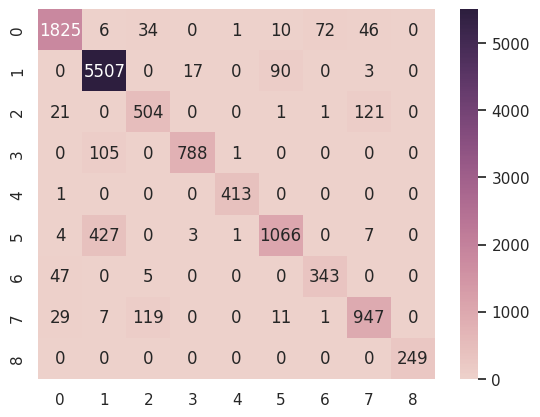

In [43]:
# Evaluacion
print("Accuracy:", accuracy_score(y_test, y_pred)) #Predicciones correctas sobre Total de muestras
print("Indice Jaccard: ", jaccard_score(y_test, y_pred, average='macro') )
print("Reporte de clasificacion:")
print(classification_report(y_test, y_pred))
print("Matriz de Confusion:")
cf_matrix_knn = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix_knn, annot=True, cmap=sns.cubehelix_palette(as_cmap=True), fmt='g')

# <font color='#4C5FDA'><small>**Entrenamiento del clasificador KNN usando todos los datos**</small></font>

In [44]:
# NO MODIFIQUES ESTA CELDA
# Clasificar toda la imagen para su visualización
full_img_prediction = knn.predict(img.reshape((-1, img.shape[2]))) #Redimensionar  cada pixel es una fila
pred_knn = full_img_prediction.reshape((img.shape[0], img.shape[1]))
gt_flat = gt.ravel()
mask = gt_flat != 0
gt_filtered = gt_flat[mask]
full_img_prediction_filtered = full_img_prediction[mask]

print("Accuracy:", accuracy_score(gt_filtered, full_img_prediction_filtered))
print("Reporte de clasificacion:")
print(classification_report(gt_flat, full_img_prediction))

Accuracy: 0.9264307088086777
Reporte de clasificacion:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00    164624
           1       0.17      0.93      0.28      6631
           2       0.24      0.99      0.39     18649
           3       0.24      0.81      0.37      2099
           4       0.13      0.90      0.22      3064
           5       0.44      1.00      0.61      1345
           6       0.11      0.77      0.19      5029
           7       0.43      0.88      0.58      1330
           8       0.22      0.90      0.35      3682
           9       0.09      1.00      0.16       947

    accuracy                           0.19    207400
   macro avg       0.21      0.82      0.32    207400
weighted avg       0.04      0.19      0.07    207400



# <font color='#4C5FDA'><small>**Graficar la prediccion del clasificador KNN**</small></font>

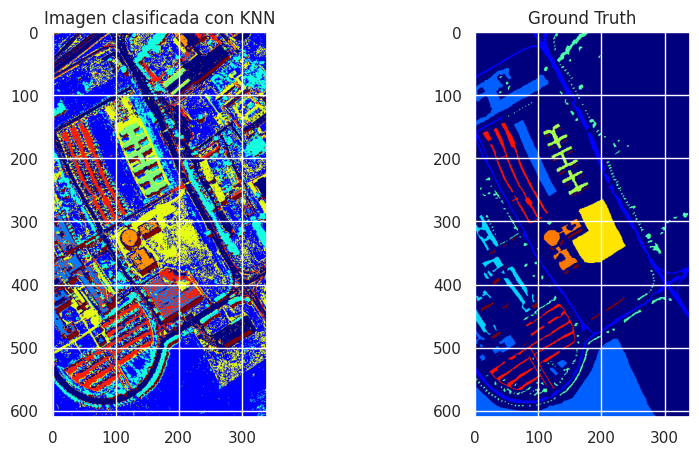

In [45]:
# Trazar la imagen clasificada

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(pred_knn, cmap='jet')
plt.title('Imagen clasificada con KNN')
plt.subplot(1, 2, 2)
plt.imshow(gt, cmap='jet')
plt.title('Ground Truth')
plt.show()

# <font color='#4C5FDA'><small>**Preprocesamiento para el clasificador Decision Tree**</small></font>

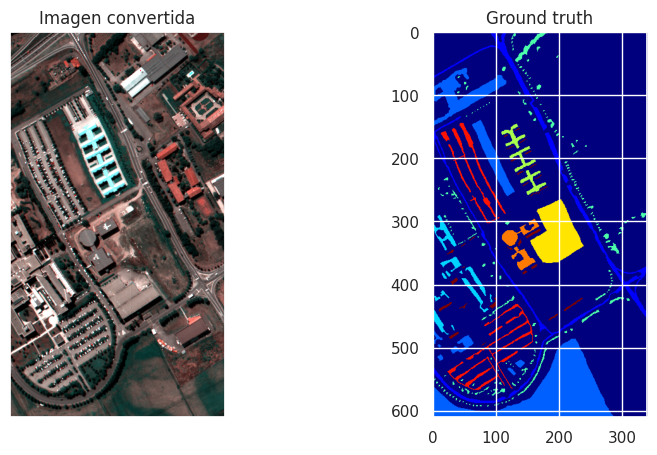

In [46]:
# NO MODIFIQUES ESTA CELDA

df = pd.DataFrame(img.reshape(img.shape[0]*img.shape[1], -1)) #Data Frame tantas 207.400 pixeles filas y 103 bandas espectrales columnas
df.columns = [f'band{i}' for i in range(1, df.shape[-1]+1)]   # Nombra cada una de las bandas espectrales band1 band2 ... Nombra las columnas
df['class'] = gt.ravel()                                        # Agrega la columna class ground truth para cada pixel
df = df[df['class']!=0]     #Se eliminan las filas, pixeles que no tiene ground truth

stacked_bands = np.transpose(img, (2, 0, 1))      # Re dimensiona el cubo de (alto, ancho, bandas) a (bandas, alto, ancho)
sampled_bands = np.array([stacked_bands[0], stacked_bands[50], stacked_bands[100]]) # Se crea una imagen falsa de color, R G B
bands = [f'Band {i}' for i in range(1, 102, 50)]  #
colors = list(mcolors.BASE_COLORS)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
epp.plot_rgb(
    stacked_bands,
    rgb=(60, 30, 27),
    stretch=True,
    figsize=(10, 10),
    ax=plt.gca(),
)
plt.title('Imagen convertida')
plt.subplot(1, 2, 2)
plt.imshow(gt, cmap='jet')
plt.title('Ground truth')
plt.show()

# <font color='#ECA702'>**<font color="#FF0000">R</font><font color="#FF7F00">e</font><font color="#FFFF00">t</font><font color="#00FF00">o</font> #<font color="#0000FF">2</font>** 💪</font>
* Construye el clasificador Decision Tree, ayudate de la documentacion oficial en el siguiente enlace: https://scikit-learn.org/stable/modules/tree.html

In [47]:
print(df.head(5))


    band1  band2  band3  band4  band5  band6  band7  band8  band9  band10  \
91   1447   1113    973   1053   1180   1263   1285   1320   1283    1295   
92   1203   1304   1402   1525   1586   1560   1461   1430   1434    1453   
93   1579   1498   1299   1208   1251   1282   1291   1257   1221    1183   
94    562    850   1020   1075   1008    914    992    998    929     930   
95   1188   1174   1189   1383   1451   1433   1452   1486   1518    1520   

    ...  band95  band96  band97  band98  band99  band100  band101  band102  \
91  ...    1788    1749    1696    1708    1714     1698     1660     1643   
92  ...    1103    1096    1113    1164    1167     1109     1075     1126   
93  ...    1116    1100    1116    1122    1138     1146     1137     1145   
94  ...    2122    2112    2144    2142    2109     2135     2139     2130   
95  ...    1749    1728    1683    1651    1620     1582     1556     1574   

    band103  class  
91     1610      1  
92     1182      1  
93   

In [49]:
x = df.drop(['class'], axis=1)  # Los pixeles con sus 103 bandas espectrales
y = df['class']                 # class aparte

print(x.head(5))
print(y.head(5))

    band1  band2  band3  band4  band5  band6  band7  band8  band9  band10  \
91   1447   1113    973   1053   1180   1263   1285   1320   1283    1295   
92   1203   1304   1402   1525   1586   1560   1461   1430   1434    1453   
93   1579   1498   1299   1208   1251   1282   1291   1257   1221    1183   
94    562    850   1020   1075   1008    914    992    998    929     930   
95   1188   1174   1189   1383   1451   1433   1452   1486   1518    1520   

    ...  band94  band95  band96  band97  band98  band99  band100  band101  \
91  ...    1793    1788    1749    1696    1708    1714     1698     1660   
92  ...    1123    1103    1096    1113    1164    1167     1109     1075   
93  ...    1127    1116    1100    1116    1122    1138     1146     1137   
94  ...    2139    2122    2112    2144    2142    2109     2135     2139   
95  ...    1747    1749    1728    1683    1651    1620     1582     1556   

    band102  band103  
91     1643     1610  
92     1126     1182  
93   

In [50]:
# NO MODIFIQUES ESTA CELD

le = preprocessing.LabelEncoder()
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.7, stratify = y)
y_encoder = le.fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [53]:
dt = DecisionTreeClassifier()
model_dt = dt.fit(x_train.values, y_train)
y_pred = model_dt.predict(x_test.values)

In [58]:
dt.get_depth()
from sklearn.tree import plot_tree
plot_tree(dt)

[Text(0.4112134056758822, 0.9875, 'x[10] <= 860.5\ngini = 0.755\nsamples = 29943\nvalue = [4642, 13054, 1469, 2145, 942, 3520, 931, 2577, 663]'),
 Text(0.08394420739062113, 0.9625, 'x[68] <= 836.5\ngini = 0.503\nsamples = 18310\nvalue = [481, 12448, 8, 2098, 0, 2582, 8, 27, 658]'),
 Text(0.24757880653325168, 0.9750000000000001, 'True  '),
 Text(0.01536861646186613, 0.9375, 'x[101] <= 805.0\ngini = 0.515\nsamples = 2218\nvalue = [4, 166, 0, 1387, 0, 3, 0, 0, 658]'),
 Text(0.014699506629512775, 0.9125, 'gini = 0.0\nsamples = 658\nvalue = [0, 0, 0, 0, 0, 0, 0, 0, 658]'),
 Text(0.016037726294219484, 0.9125, 'x[68] <= 755.5\ngini = 0.198\nsamples = 1560\nvalue = [4, 166, 0, 1387, 0, 3, 0, 0, 0]'),
 Text(0.006021988491180198, 0.8875, 'x[95] <= 1298.5\ngini = 0.04\nsamples = 1124\nvalue = [2, 21, 0, 1101, 0, 0, 0, 0, 0]'),
 Text(0.005352878658826843, 0.8625, 'gini = 0.0\nsamples = 2\nvalue = [2, 0, 0, 0, 0, 0, 0, 0, 0]'),
 Text(0.006691098323533554, 0.8625, 'x[82] <= 5093.0\ngini = 0.037\nsam

Error in callback <function flush_figures at 0x7f5c44230400> (for post_execute):


KeyboardInterrupt: 

Accuracy Score:  88.1 %
Indice Jaccard:  0.7667975537680335
Reporte de clasificacion:
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      1989
           1       0.93      0.94      0.93      5595
           2       0.67      0.69      0.68       630
           3       0.89      0.89      0.89       919
           4       0.99      0.98      0.99       403
           5       0.81      0.78      0.80      1509
           6       0.76      0.75      0.76       399
           7       0.79      0.80      0.80      1105
           8       1.00      1.00      1.00       284

    accuracy                           0.88     12833
   macro avg       0.86      0.86      0.86     12833
weighted avg       0.88      0.88      0.88     12833

Confusion Matrix:


<Axes: >

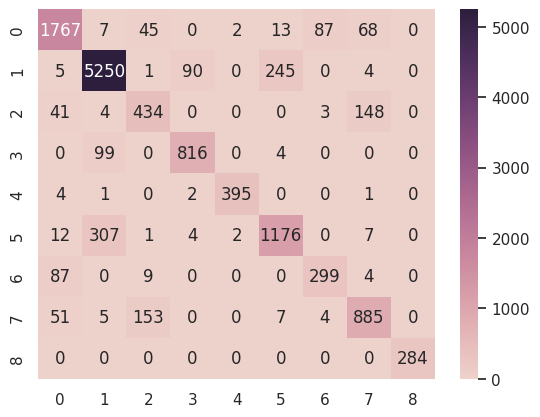

In [59]:
# Evaluacion
print("Accuracy Score: ", round(accuracy_score(y_test, y_pred), 3)*100, "%")
print("Indice Jaccard: ", jaccard_score(y_test, y_pred, average='macro'))
print("Reporte de clasificacion:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
cf_matrix_dt = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix_dt, annot=True, cmap=sns.cubehelix_palette(as_cmap=True), fmt='g')

# <font color='#4C5FDA'><small>**Entrenamiento del clasificador Decision Tree**</small></font>

In [60]:
l = [] #Itera todos los pixeles para generar su prediccion
for i in range(img.shape[0]*img.shape[1]):
    if i in list(df.index):
        l.append(le.inverse_transform(model_dt.predict([df.loc[i, :][:-1]]))) # df contiene los pixeles con clases distintas a cero
    else:
        l.append(0)  # se le asigna la clase cero

pred_dt = np.array(l, dtype=object).reshape(gt.shape).astype('float') # se reestrucutura a imagen

# <font color='#4C5FDA'><small>**Graficar la prediccion del clasificador Decision Tree**</small></font>

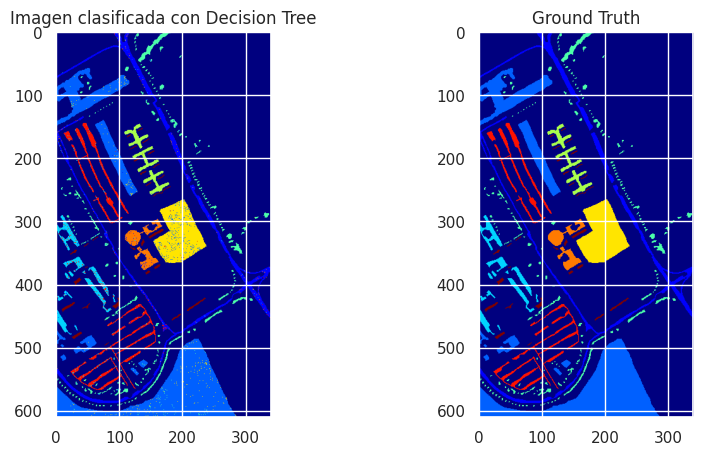

In [61]:
# Trazar la imagen clasificada

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(pred_dt, cmap='jet')
plt.title('Imagen clasificada con Decision Tree')
plt.subplot(1, 2, 2)
plt.imshow(gt, cmap='jet')
plt.title('Ground Truth')
plt.show()

# <font color='#ECA702'>**<font color="#FF0000">R</font><font color="#FF7F00">e</font><font color="#FFFF00">t</font><font color="#00FF00">o</font> #<font color="#0000FF">3</font>** 💪</font>
* Evalúa el modelo de redes neuronales que implementamos para que visualices los resultados de esta clasificación.


# <font color='#4C5FDA'><small>**Declaracion del modelo**</small></font>

In [ ]:
# NO MODIFIQUES ESTA CELDA

class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.cv1 = nn.Conv3d(1, 8, kernel_size=(3,3, 5))
        self.cv2 = nn.Conv2d(8, 16, kernel_size=(3,3))
        self.fc1 = nn.Linear(100048, 128)
        self.dp = nn.Dropout(p=0.4)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        out = self.cv1(x)
        out = F.relu(out)
        out = torch.reshape(out, (out.shape[0], out.shape[1], out.shape[2], out.shape[3]*out.shape[4]))
        out = self.cv2(out)
        out = F.relu(out)
        out = torch.flatten(out, 1)
        out = self.fc1(out)
        out = self.dp(out)
        out = F.relu(out)
        out = self.fc2(out)
        return out

In [ ]:
def zeros_pad(x, margin):
    padded_x = torch.zeros((x.shape[0] + 2 * margin, x.shape[1] + 2 * margin, x.shape[2]))
    padded_x[margin:x.shape[0] + margin, margin:x.shape[1] + margin, :] = x
    return padded_x

def create_image(x, y, window_size):
    margin = (window_size - 1) // 2
    padded_x = zeros_pad(x, margin=margin)
    patched_x = torch.zeros((x.shape[0] * x.shape[1], window_size, window_size, x.shape[2]))
    patched_y = torch.zeros((x.shape[0] * x.shape[1]))
    patch_index = 0
    for i in range(margin, padded_x.shape[0] - margin):
        for j in range(margin, padded_x.shape[1] - margin):
            patch = padded_x[i - margin:i + margin + 1, j - margin:j + margin + 1]
            patched_x[patch_index, :, :, :] = patch
            patched_y[patch_index] = y[i-margin, j-margin]
            patch_index += 1
    patched_x = patched_x[patched_y>0,:,:,:]
    patched_y = patched_y[patched_y>0]
    patched_y -= 1
    return patched_x, patched_y

# <font color='#4C5FDA'><small>**Cargamos los modelos necesarios**</small></font>

In [ ]:
# NO MODIFIQUES ESTA CELDA

# Cargar el modelo de Deep Learning completo
model = torch.load('complete_model.pth', weights_only=False)
model.eval()

CNNModel(
  (cv1): Conv3d(1, 8, kernel_size=(3, 3, 5), stride=(1, 1, 1))
  (cv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=100048, out_features=128, bias=True)
  (dp): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=128, out_features=9, bias=True)
)

In [ ]:
# NO MODIFIQUES ESTA CELDA

# Cargar el modelo PCA
pca = joblib.load('model_pca.pkl')

# Cargar los conjuntos de datos particionados
cnn_x_train = torch.load('cnn_x_train.pth')
cnn_x_test = torch.load('cnn_x_test.pth')
cnn_y_train = torch.load('cnn_y_train.pth')
cnn_y_test = torch.load('cnn_y_test.pth')

In [ ]:
# NO MODIFIQUES ESTA CELDA

dimensions = 17
window_size = 25
test_perc = 0.3

# Aquí realizamos la creación de DataLoader para la evaluación
# No necesitas aplicar PCA de nuevo, ya que los datos ya están transformados y listos para usarse
test = torch.utils.data.TensorDataset(cnn_x_test, cnn_y_test)
testloader = torch.utils.data.DataLoader(test, batch_size=10, shuffle=False)

# <font color='#4C5FDA'><small>**Ejecuta las siguientes 2 celdas para evaluar el modelo pre-entrenado**</small></font>

In [ ]:
# NO MODIFIQUES ESTA CELDA
def confusion_matrix(data, nb_classes):
    df_cm = pd.DataFrame(data,
                          range(nb_classes), range(nb_classes))
    plt.figure(figsize=(10,7))
    sns.set(font_scale=1.4) # for label size
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},cmap='Blues',
                fmt='g')
    plt.title("Confusion Matrix", fontsize = 20)
    plt.xlabel("Predicted Output", fontsize = 18)
    plt.ylabel("Expected Output", fontsize = 18)
    plt.show()

def acc_per_class(model, testloader, nb_classes):
    model.eval()
    confusion_mat = torch.zeros(nb_classes, nb_classes)
    class_correct = torch.zeros(10)
    class_total = torch.zeros(10)
    total = 0
    for inputs, labels in testloader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(labels.view(-1), preds.view(-1)):
            confusion_mat[t.long(), p.long()] += 1

    confusion_matrix(confusion_mat.data.cpu().numpy(), nb_classes)

    per_class_acc = 100*confusion_mat.diag()/confusion_mat.sum(1)
    for i, j in enumerate(per_class_acc.data.cpu().numpy()):
        print("Class:", i, "Accuracy:", j)
    acc = torch.mean(per_class_acc).data.cpu().numpy()
    print("Overall Accuracy: ", acc, "%")

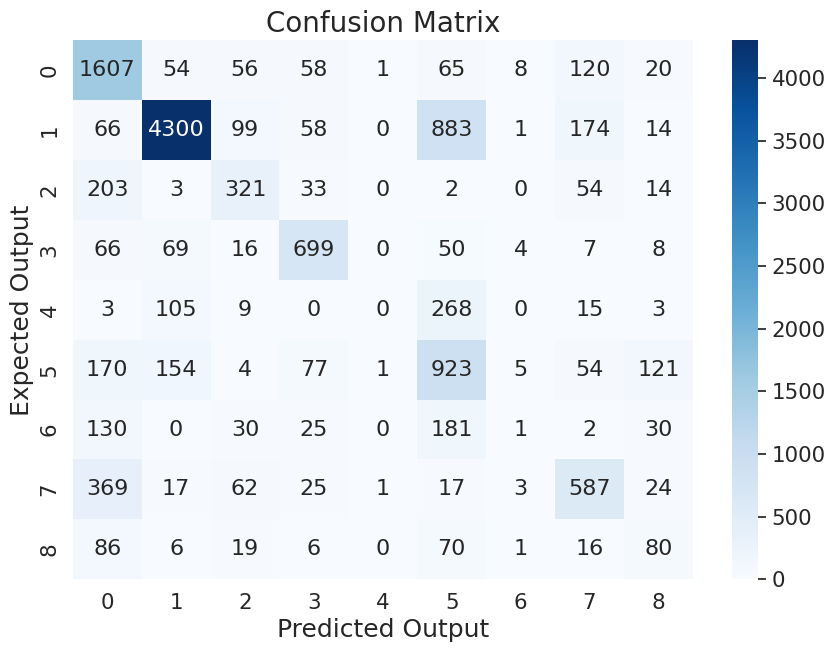

Class: 0 Accuracy: 80.79437
Class: 1 Accuracy: 76.85433
Class: 2 Accuracy: 50.95238
Class: 3 Accuracy: 76.060936
Class: 4 Accuracy: 0.0
Class: 5 Accuracy: 61.166336
Class: 6 Accuracy: 0.25062656
Class: 7 Accuracy: 53.122173
Class: 8 Accuracy: 28.169014
Overall Accuracy:  47.485577 %


In [ ]:
# NO MODIFIQUES ESTA CELDA
x = np.reshape(img, (-1, img.shape[2]))
x_pca = pca.fit_transform(x)
x_pca = np.reshape(x_pca, (img.shape[0], img.shape[1], dimensions))
padded_x = zeros_pad(torch.tensor(x_pca), window_size//2)

pred = np.zeros((gt.shape[0], gt.shape[1]))
for h in range(gt.shape[0]):
    for w in range(gt.shape[1]):
        if int(gt[h, w]) == 0:
            continue
        else:
            model.eval()
            image_patch = padded_x[h:h+window_size, w:w+window_size, :]
            image = torch.permute(image_patch[None, None, :, :, :], (0, 1, 4, 2, 3))
            pred[h][w] = model(image).argmax(dim=1) + 1

acc_per_class(model, testloader, 9)


# <font color='#4C5FDA'><small>**Ejecuta la siguiente celda para obtener el Índice de Jaccard**</small></font>

In [ ]:
# NO MODIFIQUES ESTA CELDA
def jaccard_coefficient(pred, gt, nb_classes):
    jaccard_per_class = np.zeros(nb_classes)
    for cls in range(1, nb_classes + 1):  # Class labels start from 1
        pred_cls = pred == cls
        gt_cls = gt == cls
        intersection = np.logical_and(pred_cls, gt_cls).sum()
        union = np.logical_or(pred_cls, gt_cls).sum()
        if union == 0:
            jaccard_per_class[cls - 1] = np.nan  # To handle division by zero
        else:
            jaccard_per_class[cls - 1] = intersection / union
    return np.nanmean(jaccard_per_class), jaccard_per_class  # Return average and per-class Jaccard

In [ ]:
# NO MODIFIQUES ESTA CELDA
nb_classes = 9  # Número de clases
avg_jaccard, jaccard_per_class = jaccard_coefficient(pred, gt, nb_classes)
print("Average Jaccard Coefficient:", avg_jaccard)
print("Jaccard Coefficient per Class:", jaccard_per_class)

Average Jaccard Coefficient: 0.9466111963450287
Jaccard Coefficient per Class: [0.93981146 0.99017724 0.91797961 0.9623621  0.99259808 0.97820163
 0.9460248  0.91296441 0.87938144]


# <font color='#4C5FDA'><small>**Graficar la prediccion del clasificador con Deep Learning**</small></font>

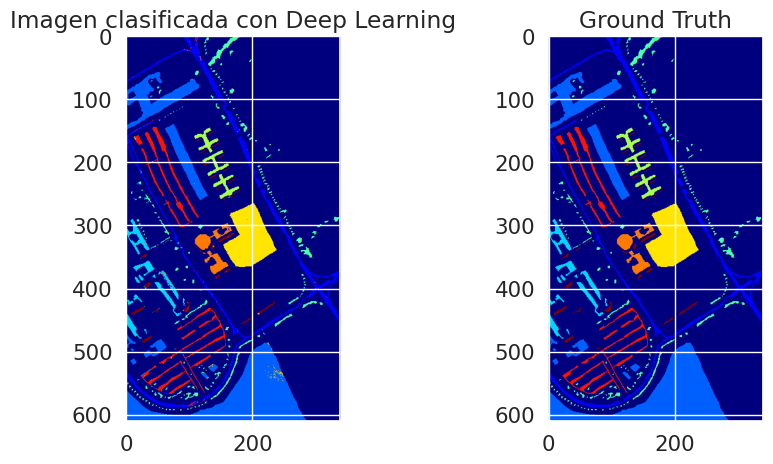

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(pred, cmap='jet')
plt.title('Imagen clasificada con Deep Learning')
plt.subplot(1, 2, 2)
plt.imshow(gt, cmap='jet')
plt.title('Ground Truth')
plt.show()

# **<font color="#FF0000">E</font><font color="#FF7F00">x</font><font color="#FFFF00">t</font><font color="#00FF00">r</font><font color="#0000FF">a</font>**: Grafica los tres resultados de los tres clasificadores y compara los resultados de manera visual. ¿Cual crees que es el mejor clasificador y por qué?

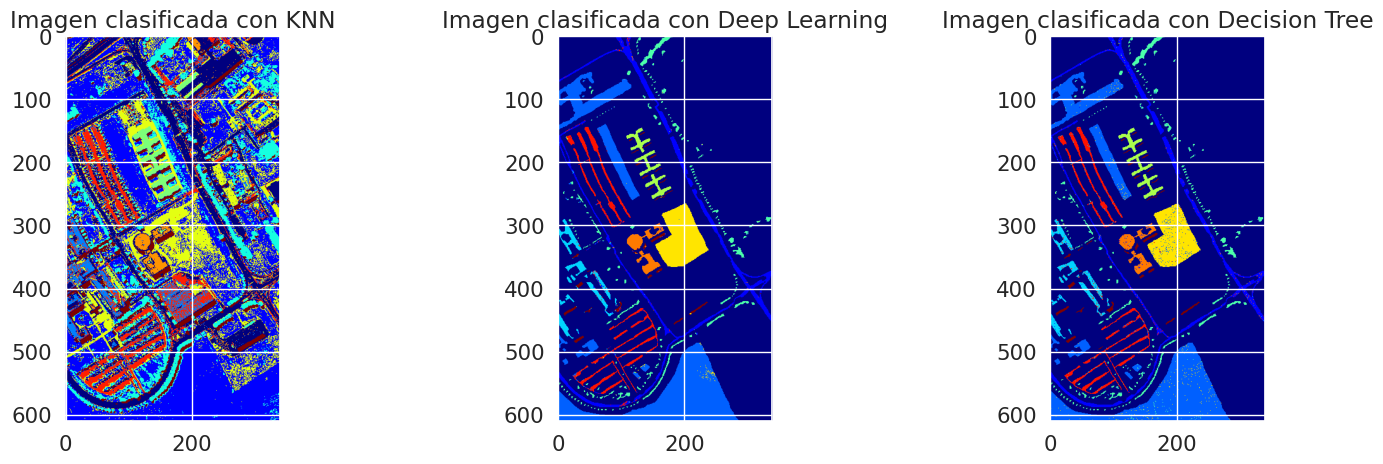

In [ ]:
None

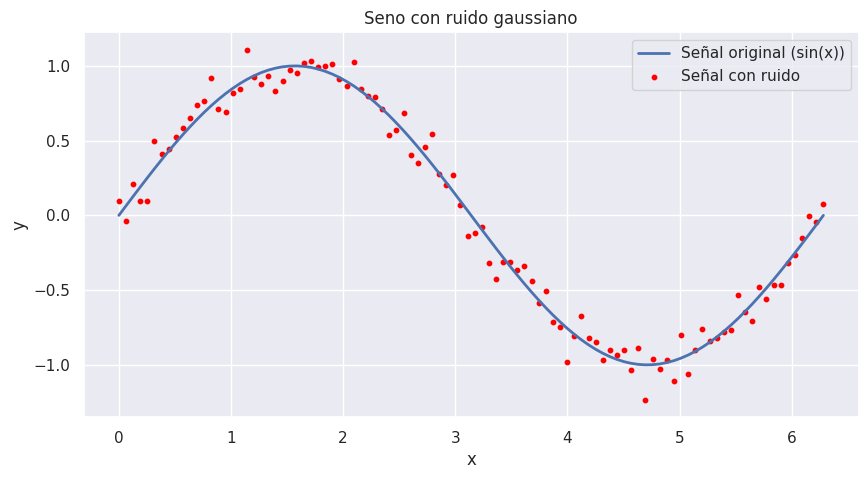

In [67]:
# Crear puntos base
x = np.linspace(0, 2 * np.pi, 100)
y_true = np.sin(x)  # Señal original

# Agregar ruido gaussiano (media=0, desviación estándar=0.1)
noise = np.random.normal(0, 0.1, size=x.shape)
y_noisy = y_true + noise

# Graficar
plt.figure(figsize=(10, 5))
plt.plot(x, y_true, label='Señal original (sin(x))', linewidth=2)
plt.scatter(x, y_noisy, color='red', label='Señal con ruido', s=10)
plt.legend()
plt.title('Seno con ruido gaussiano')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

In [100]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


dtr = DecisionTreeRegressor()


x_train, x_test, y_train, y_test = train_test_split(x, y_noisy, train_size = 0.7)

model_dtr = dtr.fit(x_train, y_train)
y_pred = model_dtr.predict(x_test)

print("MSE: ", mean_squared_error(y_test, y_pred))
print("MAE: ", mean_absolute_error(y_test, y_pred))
print("R² Score: ", r2_score(y_test, y_pred))

y_pred = model_dtr.predict(x)

MSE:  0.02568387706241567
MAE:  0.13460379895666535
R² Score:  0.9492303959563494


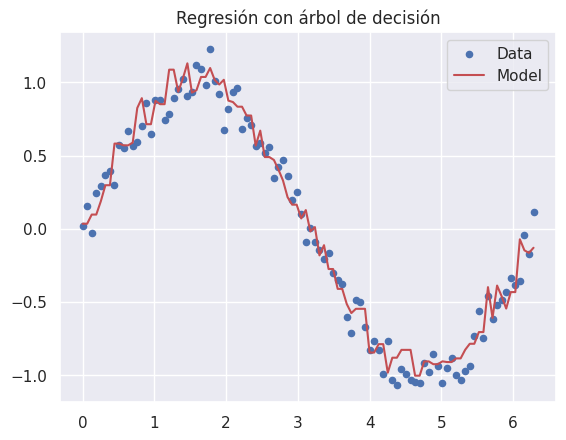

In [101]:
plt.scatter(x, y, s=20, label='Data')
plt.plot(x, y_pred, color='r', label='Model')
plt.title("Regresión con árbol de decisión")
plt.legend()
plt.show()